In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ตั้งค่าให้ Pandas แสดงผลคอลัมน์ทั้งหมด (เผื่อไฟล์มีคอลัมน์เยอะ)
pd.set_option('display.max_columns', None)

print("--- Data Exploration (EDA) ---")

# --- 1. กำหนดชื่อไฟล์และ Path ---
# path_base ชี้ไปที่โฟลเดอร์ข้อมูลที่ประมวลผลแล้ว
# เรายังต้องใช้ '../' เพราะ Notebook อยู่ใน /notebooks และ data อยู่ข้างนอก
path_base = "../data/PROCESSED/"

# file_paths เป็นแค่ชื่อไฟล์
file_paths = {
    "canals": "canals_with_dcode.csv",
    "districts": "districts.csv",
    "flood_points": "flood_points.csv",
    "floodgate": "floodgate.csv",
    "pump": "pump_readiness_corrected_dcode.csv",
    "rain": "rain_2024_combined_bkk_only.csv",
    "risk": "risk_with_dcode.csv"
}

# --- 2. โหลดไฟล์ทั้งหมดเข้า DataFrames ---
dfs = {}
print("Loading data files...")
try:
    for name, filename in file_paths.items():
        # *** นี่คือจุดที่แก้ไข ***
        # เราต้องสร้าง full_path โดยเอา path_base มาต่อกับ filename
        full_path = path_base + filename 
        
        dfs[name] = pd.read_csv(full_path)
        print(f"Successfully loaded: {name} (from {full_path})")
except FileNotFoundError as e:
    print(f"!!! Error: File not found. ตรวจสอบ Path ให้ถูกต้อง !!!")
    print(f"Python tried to look here: {e.filename}")
except Exception as e:
    print(f"An error occurred: {e}")

# --- 3. ตรวจสอบข้อมูลเบื้องต้นของแต่ละไฟล์ ---
# (ส่วนนี้เหมือนเดิม)
print("\n--- Initial Inspection (Head & Info) ---")

# ตรวจสอบว่า dfs มีข้อมูลหรือไม่ ก่อนที่จะวน loop
if dfs:
    for name, df in dfs.items():
        print(f"\n==========================================")
        print(f"Inspecting DataFrame: '{name}'")
        print(f"==========================================")
        
        print(f"\n*** Head of {name}:")
        print(df.head())
        
        print(f"\n*** Info of {name}:")
        df.info()
        
        # ตรวจสอบค่าสถิติเบื้องต้นสำหรับคอลัมน์ที่เป็นตัวเลข
        print(f"\n*** Describe (Numeric) of {name}:")
        print(df.describe())
else:
    print("\nNo dataframes were loaded. Please check file paths and errors above.")

# ตัวอย่างการเข้าถึงข้อมูล
# เช่น หากต้องการดูข้อมูล districts
# districts_df = dfs['districts']

--- Data Exploration (EDA) ---
Loading data files...
Successfully loaded: canals (from ../data/PROCESSED/canals_with_dcode.csv)
Successfully loaded: districts (from ../data/PROCESSED/districts.csv)
Successfully loaded: flood_points (from ../data/PROCESSED/flood_points.csv)
Successfully loaded: floodgate (from ../data/PROCESSED/floodgate.csv)
Successfully loaded: pump (from ../data/PROCESSED/pump_readiness_corrected_dcode.csv)
Successfully loaded: rain (from ../data/PROCESSED/rain_2024_combined_bkk_only.csv)
Successfully loaded: risk (from ../data/PROCESSED/risk_with_dcode.csv)

--- Initial Inspection (Head & Info) ---

Inspecting DataFrame: 'canals'

*** Head of canals:
         ชื่อคลอง  พื้นที่เขต  dcode          dname
0        คลองกรวย        สาทร   1028        เขตสาทร
1      คลองกระเฉด      บางเขน   1005      เขตบางเขน
2      คลองกระดาษ     บางซื่อ   1029     เขตบางซื่อ
3  คลองกระท้อนแถว  บางกอกน้อย   1020  เขตบางกอกน้อย
4  คลองกระทุ้มแจ้      ประเวศ   1032      เขตประเวศ

*** Info

In [19]:
# (โค้ดนี้รันต่อจาก Cell ที่แล้ว สมมติว่า dfs และ path_base อยู่ใน memory)

print("\n--- 4. Aggregating Data ---")

# 4.1. นับจำนวนคลอง (Canals) ต่อ dcode
# (ส่วนนี้เหมือนเดิม)
agg_canals = dfs['canals'].groupby('dcode').size().reset_index(name='canal_count')
print("Aggregated canal counts (head):")
print(agg_canals.head())

# 4.2. นับจำนวนจุดเสี่ยงน้ำท่วม (Flood Points) ต่อ dcode
# (ส่วนนี้เหมือนเดิม)
agg_flood_points = dfs['flood_points'].groupby('dcode').size().reset_index(name='flood_point_count')
print("\nAggregated flood point counts (head):")
print(agg_flood_points.head())

# 4.3. นับจำนวนประตูระบายน้ำ (Floodgates) ต่อ dcode
# (ส่วนนี้เหมือนเดิม)
agg_floodgates = dfs['floodgate'].groupby('dcode').size().reset_index(name='floodgate_count')
print("\nAggregated floodgate counts (head):")
print(agg_floodgates.head())

# ======================================================================
# --- 4.4. [REVISED] สกัดคุณลักษณะน้ำฝน (Rain Feature Extraction) ---
# นี่คือส่วนที่เราแก้ไขครับ
# (ใน 02_data_exploration.ipynb)

# --- 4.4. [แก้ไขใหม่] สกัดคุณลักษณะฝนรายฤดู (Seasonal Rain Features) ---
print("\n--- 4.4. [REVISED] Seasonal Rain Feature Extraction ---")

# 1. โหลดไฟล์ใหม่ที่เราเพิ่งสร้างจากขั้นตอนที่ 1
try:
    rain_seasonal_df = pd.read_csv('../data/PROCESSED/rain_2024_with_seasons.csv')
    print("   ... โหลด 'rain_2024_with_seasons.csv' สำเร็จ")
except Exception as e:
    print(f"!!! Error: ไม่สามารถโหลด 'rain_2024_with_seasons.csv'. {e}")
    raise

# 2. คำนวณค่าเฉลี่ยฝน (avg_rain) โดยแบ่งกลุ่มตาม 'dcode' และ 'season'
seasonal_avg = rain_seasonal_df.groupby(['dcode', 'season'])['ฝน 24 ชม.'].mean().reset_index()
print("   ... คำนวณค่าเฉลี่ยฝนรายฤดูสำเร็จ")

# 3. Pivot ตาราง
agg_rain_seasonal = seasonal_avg.pivot(
    index='dcode', 
    columns='season', 
    values='ฝน 24 ชม.'
).reset_index()

# 4. เติมค่า NaN ด้วย 0
agg_rain_seasonal = agg_rain_seasonal.fillna(0)

# 5. เปลี่ยนชื่อคอลัมน์
agg_rain_seasonal = agg_rain_seasonal.rename(columns={
    'Rainy': 'avg_rain_rainy',
    'Summer': 'avg_rain_summer',
    'Winter': 'avg_rain_winter'
})

# 6. ล้างชื่อคอลัมน์ index ที่ตกค้าง
agg_rain_seasonal.columns.name = None 

print("\n--- Pivot ตารางสำเร็จ (head) ---")
print(agg_rain_seasonal.head())

# (หมายเหตุ)
# ใน Cell ถัดไป (ส่วนที่ 5. Data Merging)
# คุณต้องแน่ใจว่าได้เปลี่ยนชื่อ DataFrame ที่จะ Merge
# จาก: 'rain': agg_rain
# เป็น: 'rain': agg_rain_seasonal
# ======================================================================


# --- 5. Data Merging (ผนวกข้อมูลทั้งหมด) ---
print("\n--- 5. Merging Data into Master DataFrame ---")

# 5.1. เริ่มจาก 'districts' เป็นตารางหลัก
master_df = dfs['districts'].copy()

# (Optional) สร้างคอลลัมน์ 'population' (ประชากรรวม) ขึ้นมาเลย
master_df['population'] = master_df['num_male'] + master_df['num_female']

# 5.2. สร้าง List ของ DataFrames ที่จะนำมาผนวก
data_to_merge = {
    'canals': agg_canals,
    'flood_points': agg_flood_points,
    'floodgates': agg_floodgates,
    'rain': agg_rain_seasonal,  # <-- ตัวแปร agg_rain นี้ จะมี 4 feature ใหม่ที่เราสร้าง
    'pump': dfs['pump'],  
    'risk': dfs['risk']   
}

# 5.3. วน Loop เพื่อ merge ข้อมูลทีละตาราง
# (ส่วนนี้เหมือนเดิม)
for name, df_to_merge in data_to_merge.items():
    print(f"Merging: {name}")
    
    if name in ['pump', 'risk']:
        if name == 'risk':
            cols_to_merge = ['dcode', 'คะแนนรวม', 'จำนวนจุดเสี่ยง', 'จำนวนจุดเฝ้าระวังน้ำท่วม']
        else:
            # สำหรับ 'pump' เราจะเอาคอลัมน์ที่ไม่ซ้ำซ้อน
            cols_to_merge = [col for col in df_to_merge.columns if col not in ['dname']]
            
        master_df = pd.merge(master_df, df_to_merge[cols_to_merge], on='dcode', how='left')
    else:
        master_df = pd.merge(master_df, df_to_merge, on='dcode', how='left')

print("All data merged.")

# --- 6. Post-Merge Cleanup (จัดการค่า NaN ที่เกิดจากการ Left Merge) ---
print("\n--- 6. Post-Merge Cleanup (Handling NaNs) ---")

# (ส่วนนี้เหมือนเดิม)
count_cols = ['canal_count', 'flood_point_count', 'floodgate_count']

for col in count_cols:
    if col in master_df.columns:
        print(f"Filling NaNs in '{col}' with 0.")
        master_df[col] = master_df[col].fillna(0)
        master_df[col] = master_df[col].astype(int)

# ตรวจสอบค่า NaN ที่อาจยังหลงเหลือ
print("\nChecking for any remaining NaNs:")
nan_info = master_df.isnull().sum()
print(nan_info[nan_info > 0])

# --- 7. บันทึกและตรวจสอบ Master DataFrame ---
print("\n--- 7. Inspecting Final Master DataFrame ---")
print(master_df.info()) # <-- ผลลัพธ์ .info() ตรงนี้จะเปลี่ยนไป (ไม่มี avg_24h_rain)
print(master_df.head())

# (ส่วนนี้เหมือนเดิม)
try:
    master_file_path = path_base + "master_district_features.csv"
    master_df.to_csv(master_file_path, index=False)
    print(f"\nSuccessfully saved Master DataFrame to:\n{master_file_path}")
except Exception as e:
    print(f"Error saving file: {e}")

# ======================================================================
# (โค้ดส่วนที่ 2 - โหลดและทำ FE - จะรันต่อโดยอัตโนมัติ)
# โค้ดส่วนนี้จะโหลดไฟล์ master_district_features.csv ที่มี feature ฝนชุดใหม่
# และจะทำงานต่อได้เลยโดยไม่ต้องแก้ไขอะไร
# ======================================================================

# --- 1. โหลด Master DataFrame ---
print("--- 1. Loading Master DataFrame for Engineering ---")
path_base = "../data/PROCESSED/"
master_df_path = path_base + "master_district_features.csv"

try:
    master_df = pd.read_csv(master_df_path)
    print(f"Successfully loaded: {master_df_path}")
except Exception as e:
    print(f"Error loading file: {e}")

# --- 2. Feature Engineering ---
print("\n--- 2. Starting Feature Engineering ---")

# (ส่วนนี้เหมือนเดิมทั้งหมด)
# 2a. สร้าง Density Features
master_df['population_density'] = master_df['population'] / (master_df['AREA'] + 1e-6)
master_df['canal_density'] = master_df['canal_count'] / (master_df['AREA'] + 1e-6)
master_df['flood_point_density'] = master_df['flood_point_count'] / (master_df['AREA'] + 1e-6)
master_df['floodgate_density'] = master_df['floodgate_count'] / (master_df['AREA'] + 1e-6)

# 2b. สร้าง Per-Capita Features
master_df['pump_per_capita'] = master_df['pump_ready'] / (master_df['population'] + 1e-6)

# 2c. สร้าง Ratio Features
master_df['pump_readiness_ratio'] = master_df['pump_ready'] / (master_df['pump_number'] + 1e-6)
master_df['pump_readiness_ratio'] = master_df['pump_readiness_ratio'].fillna(0)

print("Created Density, Per-Capita, and Ratio features.")

# 2d. One-Hot Encoding
try:
    if 'district_group' in master_df.columns:
        print("Applying One-Hot Encoding to 'district_group'...")
        dummies = pd.get_dummies(master_df['district_group'], prefix='group')
        master_df = pd.concat([master_df, dummies], axis=1)
        print("One-Hot Encoding complete. New columns (group_...) added.")
    else:
        print("'district_group' column not found for One-Hot Encoding.")
        
except Exception as e:
    print(f"Error during One-Hot Encoding: {e}")

# --- 3. บันทึกไฟล์ที่ทำ Feature Engineering แล้ว ---
engineered_file_path = path_base + "master_features_engineered.csv"
try:
    master_df.to_csv(engineered_file_path, index=False)
    print(f"\nSuccessfully saved Engineered DataFrame to:\n{engineered_file_path}")
except Exception as e:
    print(f"Error saving file: {e}")

print("\n--- Engineered DataFrame Info ---")
master_df.info() # <-- ผลลัพธ์ .info() สุดท้ายจะมี rain_max_24h, rain_sum_24h ฯลฯ


--- 4. Aggregating Data ---
Aggregated canal counts (head):
   dcode  canal_count
0   1001           12
1   1002           20
2   1003           98
3   1004           10
4   1005           37

Aggregated flood point counts (head):
   dcode  flood_point_count
0   1001                  1
1   1002                  2
2   1006                  2
3   1007                  1
4   1010                  1

Aggregated floodgate counts (head):
   dcode  floodgate_count
0   1002                1
1   1003                4
2   1007                1
3   1010                2
4   1011                1

--- 4.4. [REVISED] Seasonal Rain Feature Extraction ---
   ... โหลด 'rain_2024_with_seasons.csv' สำเร็จ
   ... คำนวณค่าเฉลี่ยฝนรายฤดูสำเร็จ

--- Pivot ตารางสำเร็จ (head) ---
   dcode  avg_rain_rainy  avg_rain_summer  avg_rain_winter
0   1001        2.158333         6.708333         5.302083
1   1002        1.441667         5.722222         3.875000
2   1003        7.983333        11.541667         6.947

In [14]:
# --- 1. โหลด Master DataFrame ---
print("--- 1. Loading Master DataFrame for Engineering ---")
path_base = "../data/PROCESSED/"
master_df_path = path_base + "master_district_features.csv"

try:
    master_df = pd.read_csv(master_df_path)
    print(f"Successfully loaded: {master_df_path}")
except Exception as e:
    print(f"Error loading file: {e}")
    # หากรันใน Notebook ต่อเนื่อง อาจใช้ master_df ตัวเดิมได้
    # แต่การโหลดใหม่จะปลอดภัยกว่า

# --- 2. Feature Engineering ---
print("\n--- 2. Starting Feature Engineering ---")

# 2a. สร้าง Density Features (เทียบกับพื้นที่ AREA)
# (เติม 1e-6 เพื่อป้องกันการหารด้วย 0, แม้ว่า AREA ไม่น่าจะเป็น 0)
master_df['population_density'] = master_df['population'] / (master_df['AREA'] + 1e-6)
master_df['canal_density'] = master_df['canal_count'] / (master_df['AREA'] + 1e-6)
master_df['flood_point_density'] = master_df['flood_point_count'] / (master_df['AREA'] + 1e-6)
master_df['floodgate_density'] = master_df['floodgate_count'] / (master_df['AREA'] + 1e-6)

# 2b. สร้าง Per-Capita Features (เทียบกับประชากร)
master_df['pump_per_capita'] = master_df['pump_ready'] / (master_df['population'] + 1e-6)

# 2c. สร้าง Ratio Features (อัตราส่วน)
master_df['pump_readiness_ratio'] = master_df['pump_ready'] / (master_df['pump_number'] + 1e-6)
# จัดการกรณี 0/0 = NaN (ถ้า pump_number = 0 และ pump_ready = 0)
master_df['pump_readiness_ratio'] = master_df['pump_readiness_ratio'].fillna(0)

print("Created Density, Per-Capita, and Ratio features.")

# 2d. One-Hot Encoding (ตามที่คุณถามมา)
# เรามีคอลัมน์ 'district_group' (จากไฟล์ pump) ที่เหมาะกับการทำ One-Hot
try:
    if 'district_group' in master_df.columns:
        print("Applying One-Hot Encoding to 'district_group'...")
        # ใช้ pd.get_dummies เพื่อสร้างคอลัมน์ใหม่สำหรับแต่ละกลุ่ม
        dummies = pd.get_dummies(master_df['district_group'], prefix='group')
        
        # ต่อ DataFrame dummies เข้ากับ master_df
        master_df = pd.concat([master_df, dummies], axis=1)
        
        print("One-Hot Encoding complete. New columns (group_...) added.")
        # (เราจะยังไม่ลบ 'district_group' ต้นฉบับ เผื่อไว้ดู)
    else:
        print("'district_group' column not found for One-Hot Encoding.")
        
except Exception as e:
    print(f"Error during One-Hot Encoding: {e}")

# --- 3. บันทึกไฟล์ที่ทำ Feature Engineering แล้ว ---
engineered_file_path = path_base + "master_features_engineered.csv"
try:
    master_df.to_csv(engineered_file_path, index=False)
    print(f"\nSuccessfully saved Engineered DataFrame to:\n{engineered_file_path}")
except Exception as e:
    print(f"Error saving file: {e}")

print("\n--- Engineered DataFrame Info ---")
master_df.info()

--- 1. Loading Master DataFrame for Engineering ---
Successfully loaded: ../data/PROCESSED/master_district_features.csv

--- 2. Starting Feature Engineering ---
Created Density, Per-Capita, and Ratio features.
Applying One-Hot Encoding to 'district_group'...
One-Hot Encoding complete. New columns (group_...) added.

Successfully saved Engineered DataFrame to:
../data/PROCESSED/master_features_engineered.csv

--- Engineered DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   OBJECTID                  50 non-null     int64  
 1   AREA                      50 non-null     float64
 2   dcode                     50 non-null     int64  
 3   dname                     50 non-null     object 
 4   dname_e                   50 non-null     object 
 5   pcode                     50 non-null     int64  
 6   pname 

--- 1. Loading FINAL Engineered DataFrame ---
Successfully loaded: ../data/PROCESSED/master_features_engineered.csv

--- 2. EDA (Histograms) on Final Features ---


/var/folders/89/hx457xt54dl3cdz1fssyz4tr0000gn/T/ipykernel_20417/1149938224.py:37: UserWarning: Glyph 3588 (\N{THAI CHARACTER KHO KHWAI}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/var/folders/89/hx457xt54dl3cdz1fssyz4tr0000gn/T/ipykernel_20417/1149938224.py:37: UserWarning: Glyph 3632 (\N{THAI CHARACTER SARA A}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/var/folders/89/hx457xt54dl3cdz1fssyz4tr0000gn/T/ipykernel_20417/1149938224.py:37: UserWarning: Glyph 3649 (\N{THAI CHARACTER SARA AE}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/var/folders/89/hx457xt54dl3cdz1fssyz4tr0000gn/T/ipykernel_20417/1149938224.py:37: UserWarning: Glyph 3609 (\N{THAI CHARACTER NO NU}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/var/folders/89/hx457xt54dl3cdz1fssyz4tr0000gn/T/ipykernel_20417/1149938224.py:37: UserWarning: Glyph 3619 (\N{THAI CHARACTER RO RUA}) missing fr

Histograms generated.


/opt/anaconda3/envs/flood_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 3588 (\N{THAI CHARACTER KHO KHWAI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/flood_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 3632 (\N{THAI CHARACTER SARA A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/flood_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 3649 (\N{THAI CHARACTER SARA AE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/flood_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 3609 (\N{THAI CHARACTER NO NU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/flood_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 3619 (\N{TH

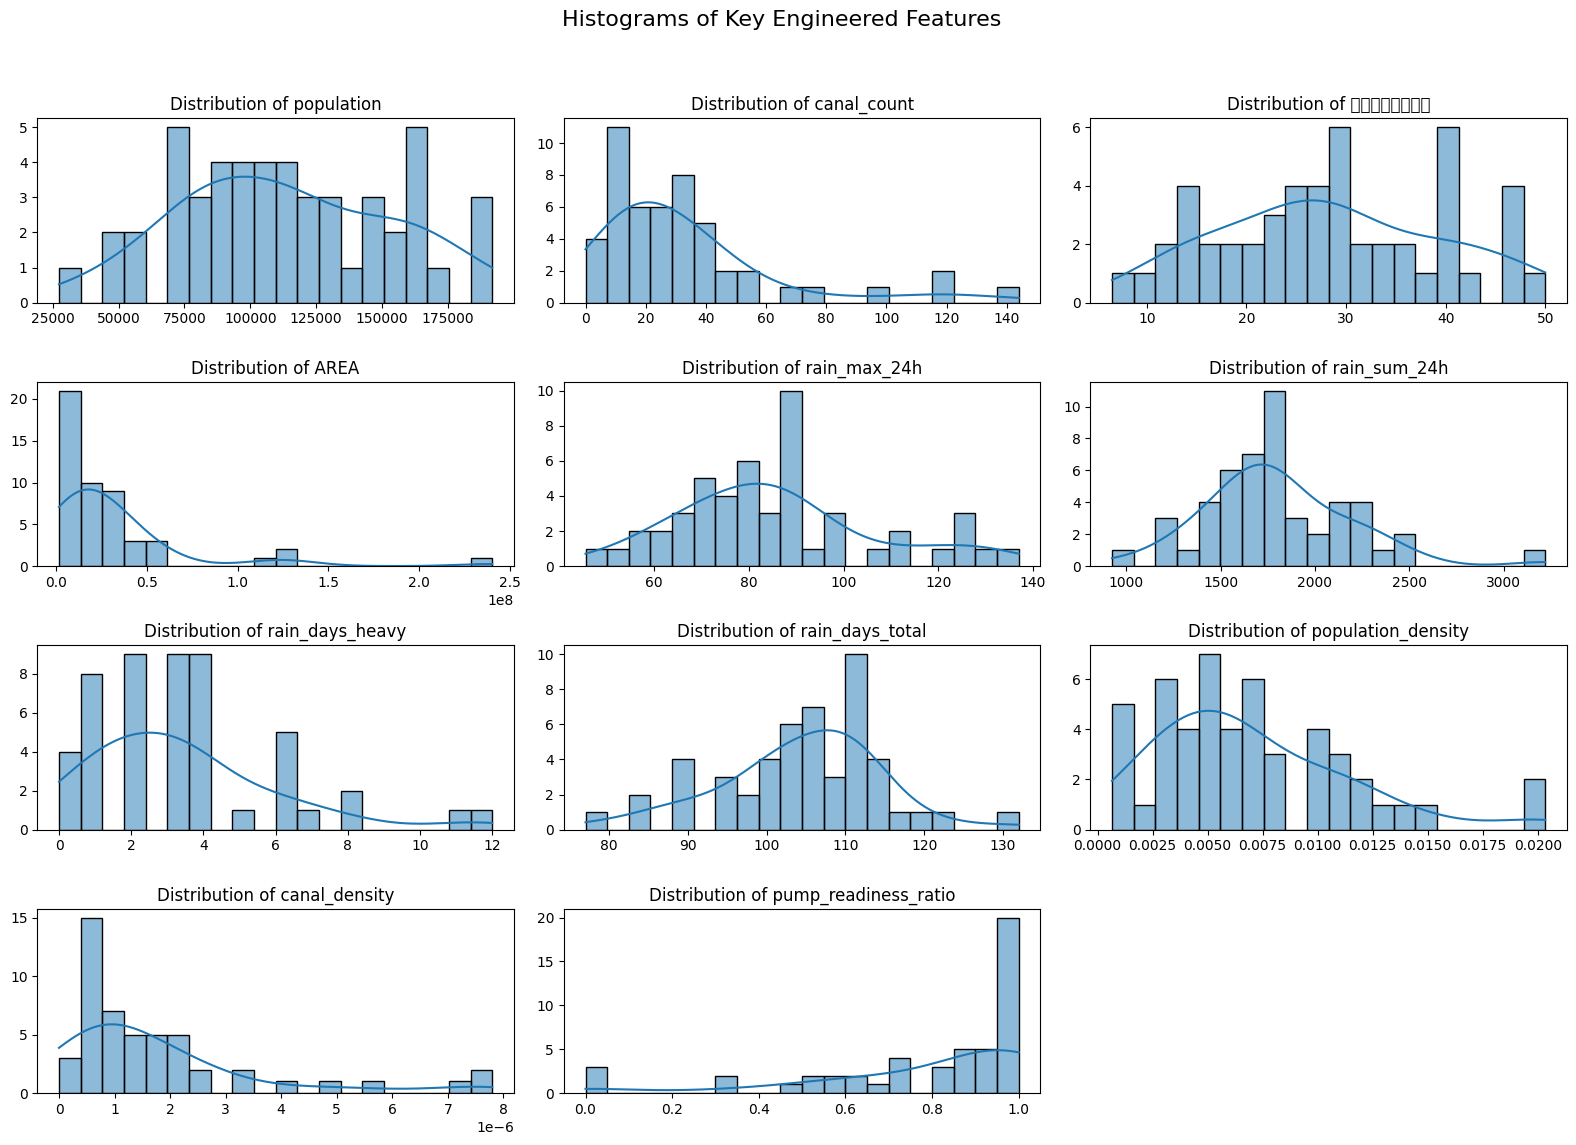


--- 3. EDA (Correlation Heatmap) for Feature Selection ---
Dropped duplicate columns (if any).


/opt/anaconda3/envs/flood_env/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 3588 (\N{THAI CHARACTER KHO KHWAI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/anaconda3/envs/flood_env/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 3632 (\N{THAI CHARACTER SARA A}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/anaconda3/envs/flood_env/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 3649 (\N{THAI CHARACTER SARA AE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/anaconda3/envs/flood_env/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 3609 (\N{THAI CHARACTER NO NU}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/anaconda3/envs/flood_env/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 3619 (\N{THAI CHARACTER RO RUA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/anaconda3/envs/flood_env/lib/python3.11/site-packages/seaborn/

Correlation heatmap generated.


/opt/anaconda3/envs/flood_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 3588 (\N{THAI CHARACTER KHO KHWAI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/flood_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 3632 (\N{THAI CHARACTER SARA A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/flood_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 3649 (\N{THAI CHARACTER SARA AE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/flood_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 3609 (\N{THAI CHARACTER NO NU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/flood_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 3619 (\N{TH

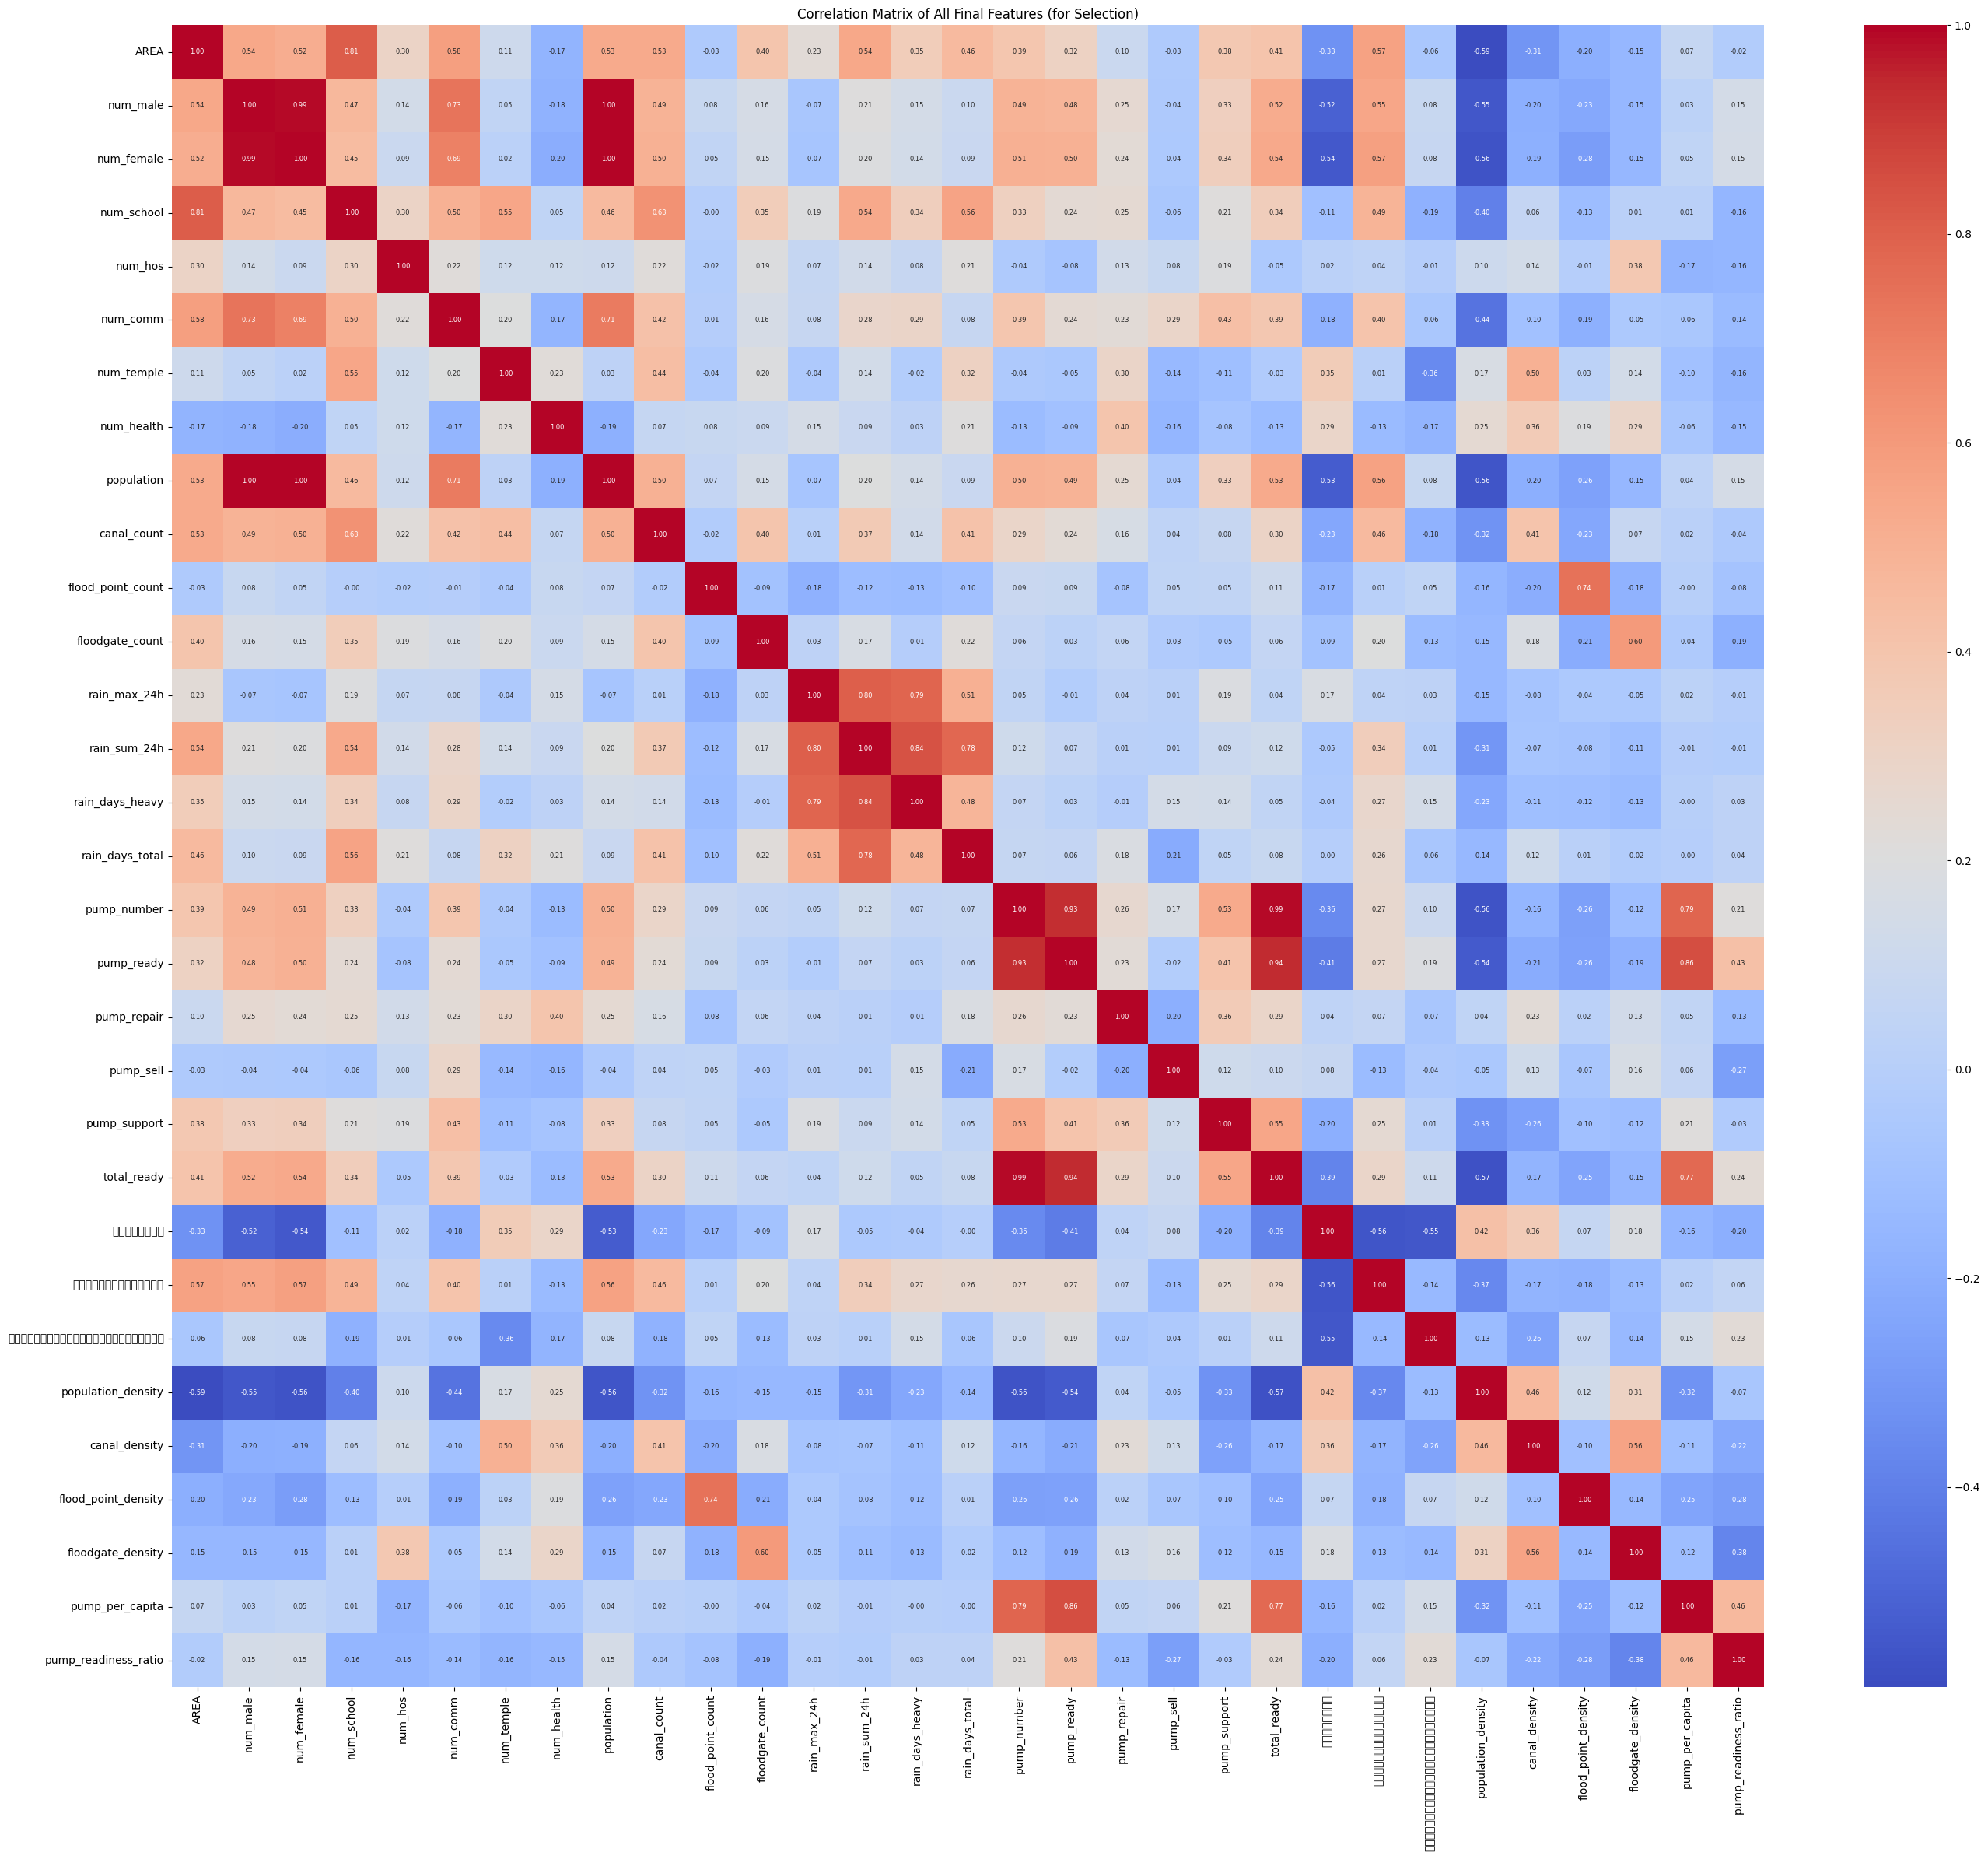


--- Highly Correlated Pairs (Correlation >= 0.9) ---
These pairs are redundant. We should pick only one from each pair:
       Feature 1    Feature 2  Correlation
33      num_male   num_female     0.989955
39      num_male   population     0.997227
70    num_female   population     0.997732
513  pump_number   pump_ready     0.931832
517  pump_number  total_ready     0.992717
548   pump_ready  total_ready     0.939523


/var/folders/89/hx457xt54dl3cdz1fssyz4tr0000gn/T/ipykernel_20417/1149938224.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_corr['pair_key'] = high_corr.apply(lambda row: '-'.join(sorted([row['Feature 1'], row['Feature 2']])), axis=1)


In [15]:
# (โค้ดนี้รันใน Cell ใหม่)
# เราจะโหลดไฟล์ Engineered ล่าสุดที่เราเพิ่งบันทึกไป

# --- 1. โหลดไฟล์ Engineered ล่าสุด ---
print("--- 1. Loading FINAL Engineered DataFrame ---")
path_base = "../data/PROCESSED/"
engineered_df_path = path_base + "master_features_engineered.csv"

try:
    df_final = pd.read_csv(engineered_df_path)
    print(f"Successfully loaded: {engineered_df_path}")
except Exception as e:
    print(f"Error loading file: {e}")

# --- 2. EDA (Histograms) - ตรวจสอบ Feature ใหม่ (โดยเฉพาะ Rain) ---
print("\n--- 2. EDA (Histograms) on Final Features ---")

# เลือก features สำคัญที่จะ plot (เน้นตัวใหม่ๆ ที่เราสร้าง)
features_to_plot = [
    'population', 'canal_count', 'คะแนนรวม', 'AREA',
    'rain_max_24h', 'rain_sum_24h', 'rain_days_heavy', 'rain_days_total',
    'population_density', 'canal_density', 'pump_readiness_ratio'
]

# กรองเอาเฉพาะคอลัมน์ที่มีอยู่ใน df_final
features_to_plot = [col for col in features_to_plot if col in df_final.columns]

plt.figure(figsize=(16, 12))
for i, col in enumerate(features_to_plot):
    plt.subplot(4, 3, i + 1)
    sns.histplot(df_final[col], kde=True, bins=20)
    plt.title(f'Distribution of {col}')
    plt.xlabel('')
    plt.ylabel('')

plt.suptitle('Histograms of Key Engineered Features', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# (Optional) บันทึกรูป
# plt.savefig('../reports/figures/02_histograms_final_engineered.png')
print("Histograms generated.")
plt.show()

# --- 3. EDA (Correlation Heatmap) - เพื่อ Feature Selection ---
print("\n--- 3. EDA (Correlation Heatmap) for Feature Selection ---")

# a) เตรียมข้อมูลสำหรับ Correlation
numeric_df = df_final.select_dtypes(include=[np.number])

# b) ลบคอลัมน์ ID หรือคอลัมน์ที่ไม่ใช่ Feature ออก
cols_to_drop = ['OBJECTID', 'dcode', 'pcode', 'budget_year', 'inspec_period']
for col in cols_to_drop:
    if col in numeric_df.columns:
        numeric_df = numeric_df.drop(col, axis=1)

# c) [สำคัญ] ลบคอลัมน์ที่ซ้ำกัน (จาก Snippet ที่คุณส่งมา ผมเห็นว่า group_* มันซ้ำ)
# .loc[:,~] เป็นวิธีที่ปลอดภัยในการเลือกลบคอลัมน์ที่ชื่อซ้ำกัน
numeric_df = numeric_df.loc[:,~numeric_df.columns.duplicated()]
print("Dropped duplicate columns (if any).")

# d) สร้าง Correlation Matrix
corr_matrix = numeric_df.corr()

# e) วาด Heatmap
plt.figure(figsize=(28, 24)) # ใช้ขนาดใหญ่เพราะ Feature เราเยอะ
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', annot_kws={"size": 6})
plt.title('Correlation Matrix of All Final Features (for Selection)')
plt.tight_layout()
# (Optional) บันทึกรูป
# plt.savefig('../reports/figures/03_correlation_heatmap_final.png')
print("Correlation heatmap generated.")
plt.show()

# f) ค้นหาคู่ที่มี Correlation สูง (>= 0.9) เพื่อช่วยในการตัดสินใจ
print("\n--- Highly Correlated Pairs (Correlation >= 0.9) ---")

corr_stacked = corr_matrix.abs().stack().reset_index()
corr_stacked.columns = ['Feature 1', 'Feature 2', 'Correlation']

# กรองเอาเฉพาะคู่ที่ > 0.9 และไม่ใช่ตัวมันเอง
high_corr = corr_stacked[
    (corr_stacked['Correlation'] >= 0.9) & 
    (corr_stacked['Feature 1'] != corr_stacked['Feature 2'])
]

# จัดการคู่ซ้ำ (A-B กับ B-A)
high_corr['pair_key'] = high_corr.apply(lambda row: '-'.join(sorted([row['Feature 1'], row['Feature 2']])), axis=1)
high_corr = high_corr.drop_duplicates(subset=['pair_key']).drop('pair_key', axis=1)

print("These pairs are redundant. We should pick only one from each pair:")
print(high_corr)